In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

from util import util
import os
import numpy as np
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import pandas as pd
from sklearn.metrics import r2_score

# Load data
data_folder = os.path.join('..', 'data')

data = util.load_communities_data(data_folder)
attributes = data.columns[3:-1]
target = data.columns[-1]

tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
nf = [a for a in attributes if a != 'race'] + [target]

tmp = data.iloc[:tr_sep]
scale = tmp[nf].max()
sdata = data.copy()
sdata[nf] /= scale[nf]

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]

protected = {'race': (0, 1)}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Projection on the Fairness Use Case

Fingers Crossed

## Projection Problem Formulation

**The projection problem for the fairness case study is given by:**

$$\begin{align}
\mathop{\rm argmin}_{\hat{y}} & \|y - z\|_2 \\
\text{subject to: } & \bar{y} = \frac{1}{m} {1}^T z \\
& \bar{y}_v = \frac{1}{\|X_{v}\|_1} X_{v} z & \forall v \in D \\
& d_v \geq \bar{y} - \bar{y}_v & \forall v \in D \\
& d_v \geq -(\bar{y} - \bar{y}_v) & \forall v \in D \\
& {1}^T d_v \leq \varepsilon
\end{align}$$

* We want to tackle that via the OSQP solver
* ...Which means we need to define its parameters $P$, $q$, $A$, $l$, $u$

## Deriving the Matrices

**We start by factoring out the $\bar{y}$ and $\bar{y}_v$ variables**

$$\begin{align}
\mathop{\rm argmin}_{z} & \frac{1}{2} z^T I z - y^T z \\
\text{subject to: } 
& \left( \frac{1}{m} - \frac{1}{\| X_{v} \|_1} X_{v} \right)^T z - d_v \leq 0 & \forall v \in D \\
& - \left( \frac{1}{m} - \frac{1}{\| X_{v} \|_1} X_{v} \right)^T z - d_v \leq 0 & \forall v \in D \\
& {1}^T d \leq \varepsilon
\end{align}$$

* We no longer have equality constraints
* Which means our problem is in the correct form

**Now, we only need to work out its matrix notation**

## Deriving the Matrices

**Our problem features two types of variables**

* The projected targets $z$
* The individual deviation terms $d$

**Hence, in matrix form the problem is defined as:**

$$\begin{align}
\mathop{\rm argmin}_{z} & \frac{1}{2} \left(\begin{array}{c}z & d\end{array}\right)^T P \left(\begin{array}{c}z & d\end{array}\right) - q^T \left(\begin{array}{c}z & d\end{array}\right) \\
\text{subject to: } 
& A \left(\begin{array}{c}z & d\end{array}\right) \leq u
\end{align}$$

* By comparison with the detailed formulation
* ...We can derive the matrix structure

## Deriving the Matrices

**For the objective we have:**

$$
\left(\begin{array}{c}z & d\end{array}\right)^T P \left(\begin{array}{c}z & d\end{array}\right) - q^T \left(\begin{array}{c}z & d\end{array}\right)
$$

Which maps in the detailed formulation to:

$$
\frac{1}{2} z^T I z - y^T z
$$

**Hence, we have:**

$$P = \left(\begin{array}{cc}
I & 0 \\
0 & 0
\end{array}\right)
\quad
\text{and}
\quad
q = \left(\begin{array}{c}
y \\
0
\end{array}\right)$$

## Deriving the Matrices

**Following the same process for the constraints leads to:**

$$A = \left(\begin{array}{cc}
\frac{1}{m} - \frac{1}{\| X \|_1} \odot X &  - I \\
-\frac{1}{m} + \frac{1}{\| X \|_1} \odot X & -I \\
0 & 1
\end{array}\right)
\quad
\text{and}
\quad
u = \left(\begin{array}{c}
0 \\
0 \\
\varepsilon
\end{array}\right)$$

* Where $\|X\|_1$ refers to the column vector $\{\|X_v\|_1\}_{v \in D}$
* ...And $\odot$ to the (broadcasted) element wise product

**Deriving these matrices is a convoluted process**

* Having a modeling library would greatly simplify it
* ...But sadly no good candidates appear to be available for OSQP

## Solving the Projection Problem

**We can now solve the projection problem**

In [6]:
tr_prj = util.project_fairness(tr['race'], tr[target], thr=0.13)

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1596, constraints m = 5
          nnz(P) + nnz(A) = 7976
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.4944e+01   4.05e-01   5.99e-01   1.00e-01   7.47e-04s
 125  -2.2899e+01   1.34e-06   4.41e-05   2.99e+01   3.11e-03s

status:               solved
number of itera

## Checking the Results

**We should evaluate two qualities in our projected targets**

* Their accuracy w.r.t. the original targets
* Their DIDI value (to make sure that everything went right)

In [4]:
print(f'Projection R2: {r2_score(tr[target], tr_prj):.2f} (train)')
print(f'Projection DIDI: {util.DIDI_r(tr, tr_prj, protected):.2f} (train)')

Projection R2: 0.96 (train)
Projection DIDI: 0.13 (train)


* We using the $R^2$ coefficient to measure accuracy
* The DIDI value is equal to the threshold
* ...Which makes sense considering that lower value come with reduced accuracy

## Training a Model

**We can now train a (simple) model on the projected targets**

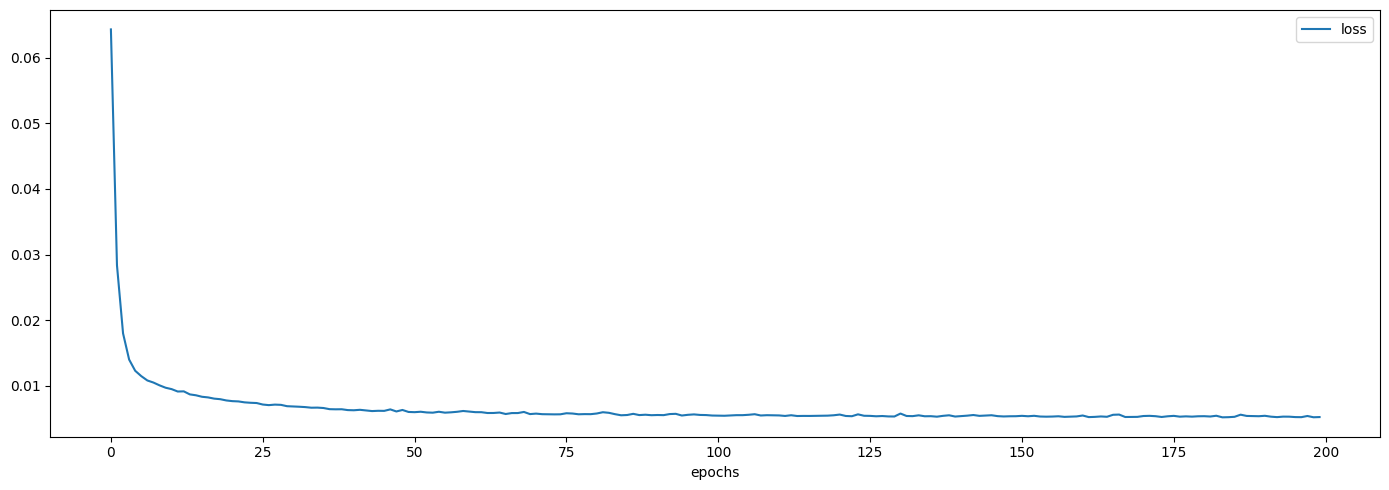

Model loss: 0.0052 (training)


In [7]:
nn_f = util.build_ml_model(input_size=len(attributes), output_size=1, hidden=[])
history = util.train_ml_model(nn_f, tr[attributes], tr_prj, validation_split=0., epochs=200)
util.plot_training_history(history, figsize=figsize)

## Evaluating the Results

**Finally, we can evaluate the results**

In [8]:
tr_pred_f = nn_f.predict(tr[attributes], verbose=0)
r2_tr_f = r2_score(tr[target], tr_pred_f)
ts_pred_f = nn_f.predict(ts[attributes], verbose=0)
r2_ts_f = r2_score(ts[target], ts_pred_f)

print(f'R2 score: {r2_tr_f:.2f} (training), {r2_ts_f:.2f} (test)')
tr_DIDI_f = util.DIDI_r(tr, tr_pred_f, protected)
ts_DIDI_f = util.DIDI_r(ts, ts_pred_f, protected)
print(f'DIDI: {tr_DIDI_f:.2f} (training), {ts_DIDI_f:.2f} (test)')

R2 score: 0.63 (training), 0.57 (test)
DIDI: 0.13 (training), 0.14 (test)


The results should be pretty good!

* There a bit overfitting
* ...Which can lead to a modest constraint violation on the test data